# SAS Viya workshop for Python data scientists
### Документация

[SAS Viya 3.5 Actions and Action Sets by Name and Product](https://go.documentation.sas.com/?cdcId=pgmsascdc&cdcVersion=9.4_3.5&docsetId=allprodsactions&docsetTarget=titlepage.htm&locale=en)

[SAS swat for Python](https://sassoftware.github.io/python-swat/)

[SASCTL for SAS Viya Model Manager](https://github.com/sassoftware/python-sasctl)


Содержание

1. Создание сессии
2. Подготовка данных для обучения моделей
3. Обучение моделей
4. Интерпритация работы модели
5. Запуск автоматического конвеера разработки модели SAS AutoML
6. Выполнение скоринга в пакетном режиме
7. Регистрация моделей в репозитории Model Manager

In [ ]:
from swat import * #библиотека для работы с аналитикой SAS Viya с помощью Python

import pandas as pd
import numpy as np
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 40
pd.options.display.max_rows = 2000
pd.options.display.float_format = lambda x: ('%7.5f' % x)
from matplotlib import pyplot as plt
from swat.render import render_html
%matplotlib inline

# 1. Создание сессии 

## 1.1 Подключение к серверу Cloud Analytic Services (CAS)

In [ ]:
cashost='10.96.2.165'
casport=5570
casuser = input("Provide your user id for the Viya server: ")
password = input("Provide your password for the Viya server: ")

sess = CAS(cashost, casport, username=casuser, password=password)

## 1.2 Загрузка action sets для сессии работы с CAS

In [ ]:
actionsets = [
    'dataStep',
    'fedSql',
    'dataSciencePilot',
    'astore',
    'cardinality',
    'sampling',
    'decisionTree',
    'neuralNet',
    'svm',
    'autotune',
    'percentile',
    'sessionProp',
    'explainModel'
]
for a in actionsets:
    sess.loadactionset(actionset = a)

sess.sessionProp.setSessOpt(caslib = 'SASWorkshopDay')

## 1.3 Загрузка таблиц для обучения и оценки моделей в RAM

In [ ]:
def load_table(name):
    _ = sess.table.loadTable(
        path = '%s.sashdat' % name,
        casout = {
            'name': name,
            'replace' : True
        },
        caslib = "SASWorkshopDay"
    )

tables_to_load = ['hmeq_loan_data_train', 'hmeq_loan_data_test', 'hmeq_customer_data']

for t in tables_to_load:
    load_table(t)

## 1.4 Получение список доступных таблиц в сессии

In [ ]:
sess.tableInfo()

# 2. Подготовка данных для обучения моделей

## 2.1 Перечень исходных полей в таблицах для обучения и оценки моделей

In [ ]:
sess.CASTable('hmeq_loan_data_train').columninfo()['ColumnInfo']

In [ ]:
sess.CASTable('hmeq_loan_data_train').columninfo()['ColumnInfo'][['Column', 'Label']]

In [ ]:
sess.CASTable('hmeq_loan_data_test').columninfo()['ColumnInfo'][['Column', 'Label']]

In [ ]:
sess.CASTable('hmeq_customer_data').columninfo()['ColumnInfo'][['Column', 'Label']]

## 2.2 Оценка качества данных в таблицах в столбец "customer gender"

In [ ]:
sess.CASTable('hmeq_customer_data').customer_gender.value_counts()

In [ ]:
type(sess.CASTable('hmeq_customer_data').customer_gender.value_counts())

In [ ]:
len(sess.CASTable('hmeq_customer_data')) - sess.CASTable('hmeq_customer_data').customer_gender.value_counts().sum()

## 2.3 Запуск процедуры Data Quality для устранения пропущенных значений в столбце "customer gender"

In [ ]:
r = sess.dataStep.runcode(code = '''
    data hmeq_customer_data_mod;
        set hmeq_customer_data;
        if customer_gender notin ("M", "F") then customer_gender = dqgender(customer_name, "Name", "ENUSA");
        drop customer_name;
    run;
''')

In [ ]:
sess.CASTable('hmeq_customer_data_mod').customer_gender.value_counts()

In [ ]:
len(sess.CASTable('hmeq_customer_data_mod')) - sess.CASTable('hmeq_customer_data_mod').customer_gender.value_counts().sum()

## 2.4 Join таблицы для обучения и справочника в CAS

In [ ]:
def join(partition):
    query = '''
    create table SASWorkshopDay.hmeq_{partition} {{options replace=TRUE}} as
    select
        a.bad,
        a.reason,
        a.loan,
        b.*
    from
        SASWorkshopDay.hmeq_loan_data_{partition} a
        left join
        SASWorkshopDay.hmeq_customer_data_mod b
        on
            a.Customer_ID = b.Customer_ID
    ;
    '''.format(partition = partition)
    sess.fedSql.execDirect(query)

join('train')
join('test')

## 2.5 Партицирование - разбиение обучающей выборки на train и validate

In [ ]:
sess.sampling.stratified(
    table = {
        'name': 'hmeq_train',
        'groupBy': {'bad'}
    },
    partInd = True,
    sampPct = 30,
    output = {
        'casOut': {
            'name': 'hmeq_train_val',
            'replace': True
        },
        'copyVars': 'ALL'
    },
    seed = 1234
)

In [ ]:
sess.CASTable('hmeq_train_val').head(5)

In [ ]:
sess.CASTable('hmeq_train_val')._PartInd_.mean()

In [ ]:
sess.CASTable('hmeq_train_val').query('_partind_ = 0').BAD.mean()

In [ ]:
sess.CASTable('hmeq_train_val').query('_partind_ = 1').BAD.mean()

## 2.6 Заполнение пропусков в исходных переменных

In [ ]:
_ = sess.cardinality.summarize(
    table = {
        'name': 'hmeq_train_val',
        'where': '_partind_ = 0'
    }, 
    cardinality = {
        'name': 'data_card',
        'replace': True
    }
)

In [ ]:
sess.CASTable('data_card').head(10)

In [ ]:
sess.CASTable('data_card').fetch(to = 100)

In [ ]:
sess.CASTable('data_card').query('_NMISS_ > 0').fetch(to = 100)

In [ ]:
data_card_df = sess.CASTable('data_card').query('_NMISS_ > 0').to_frame(fetchvars = ['_VARNAME_', '_NMISS_', '_NOBS_'])
type(data_card_df)

In [ ]:
# Доли пропущенных значений
data_card_df['PERCENT_MISSING'] = (data_card_df['_NMISS_'] / data_card_df['_NOBS_']) * 100

In [ ]:
# Гистограмма по пропущенным значениям
tbl_forplot = pd.Series(list(data_card_df['PERCENT_MISSING']), index = list(data_card_df['_VARNAME_']))
ax = tbl_forplot.plot(
    kind = 'bar', 
    title = 'Percentage of Missing Values',
    figsize = (11, 5)
)
ax.set_ylabel('Percent Missing')
ax.set_xlabel('Variable Names');

In [ ]:
sess.dataPreprocess.transform(
    table = {
        'name': 'hmeq_train_val',
        'where': '_partind_ = 0'
    },
    copyAllVars = True,
    outVarsNameGlobalPrefix = 'IM',
    requestPackages = [
        {
            'impute': {
                'method': 'MEAN'
            },
            'inputs': {
                'clage',
                'clno',
                'loan',
                'mortdue',
                'value',
                'delinq',
                'debtinc',
                'yoj',
                'ninq',
                'derog'
            }
        },
        {
            'impute': {
                'method': 'MODE'
            },
            'inputs': {
                'job',
                'reason'
            }
        }
    ],
    code = {
        'casout': {
            'name': 'impute_score_code',
            'replace': True
        }
    }
)

In [ ]:
sess.CASTable('impute_score_code').fetch(to = 10)

In [ ]:
sess.dataStep.runCodeTable(
    table = 'hmeq_train_val',
    codeTable = 'impute_score_code',
    casout = 'hmeq_train_val_abt'
)
sess.dataStep.runCodeTable(
    table = 'hmeq_test',
    codeTable = 'impute_score_code',
    casout = 'hmeq_test_abt'
)

In [ ]:
raw_inputs = [
    v for v in sess.CASTable('hmeq_train_val').columninfo()['ColumnInfo']['Column']
    if v not in {'BAD', '_PartInd_', 'Customer_ID'}
]
raw_inputs_imp = [
    'IM_%s' % v
    for v in [
        'clage', 'clno', 'loan', 'mortdue',
        'value', 'delinq', 'debtinc', 'yoj',
        'ninq', 'derog', 'job', 'reason'
    ]
]

In [ ]:
raw_inputs

## 2.7 Смотрим итоговую ABT

In [ ]:
sess.CASTable('hmeq_train_val_abt').head(10)

# 3.Обучение моделей

## 3.1 Random Forest

In [ ]:
rf = sess.decisionTree.forestTrain(
    table={
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    inputs = raw_inputs,
    nominals = ['bad'],
    target = 'bad',
    nTree = 20,
    nBins = 20,
    leafSize = 5,
    maxLevel = 21,
    crit = 'GAINRATIO',
    varImp = True,
    seed = 1234,
    OOB = True,
    vote = 'PROB',
    saveState = {
        'name': 'forest_ast',
        'replace': True
    },
    nthreads = 3
)

In [ ]:
rf

In [ ]:
var_imp = rf['DTreeVarImpInfo']
plt.figure(figsize=(5, 5))
_ = plt.barh(
    y = var_imp.Variable,
    width = var_imp.Importance
)

## 3.2 Gradient Boosting

In [ ]:
gb = sess.decisionTree.gbtreeTrain(
    table = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    validTable = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 1'
    },
    earlyStop = {
        'metric': 'logloss',
        'minimum': True,
        'stagnation': 5
    },
    inputs = raw_inputs,
    nominals = ['bad'],
    target = 'bad',
    seed = 1234,
    nTree = 100,
    learningRate = 0.1,
    nBins = 20,
    maxLevel = 3,
    varImp = True,
    saveState = {
        'name': 'gb_ast',
        'replace': True
    }
)

## 3.3 Random Forest Autotune

In [ ]:
rf = sess.autotune.tuneForest(
    trainOptions = {
        'table': {
            'name': 'hmeq_train_val_abt',
            'where': '_partind_ = 0'
        },
        'inputs': raw_inputs,
        'nominals': ['bad'],
        'target': 'bad',
        'nBins': 20,
        'nTree': 20,
        'leafSize': 5,
        'maxLevel': 21,
        'crit': 'GAINRATIO',
        'varImp': True,
        'seed': 1234,
        'OOB': True,
        'vote': 'PROB',
        'saveState': {
            'name': 'forest_auto_ast',
            'replace': True
        }
    },
    tunerOptions = {
        'searchMethod': 'GA',
        'popSize': 10,
        'objective': 'AUC',
        'maxIters': 3,
        'enableLocalSearch': False,
        'nFolds': 5
    },
    tuningParameters = [
        {
            'namePath': 'bootstrap',
            'initValue': 0.5,
            'lowerBound': 0.001,
            'upperBound': 1
        }
    ],
    useParameters = 'CUSTOM'
)

## 3.4 Model Composer

### Байесовская оптимизация

$$
f(x) \sim N(\mu(x), \Sigma(x, x)) \quad EI(x) = E[\max(f(x) - f(\widehat{x^*}), 0) \mid I] \rightarrow \max\limits_x
$$

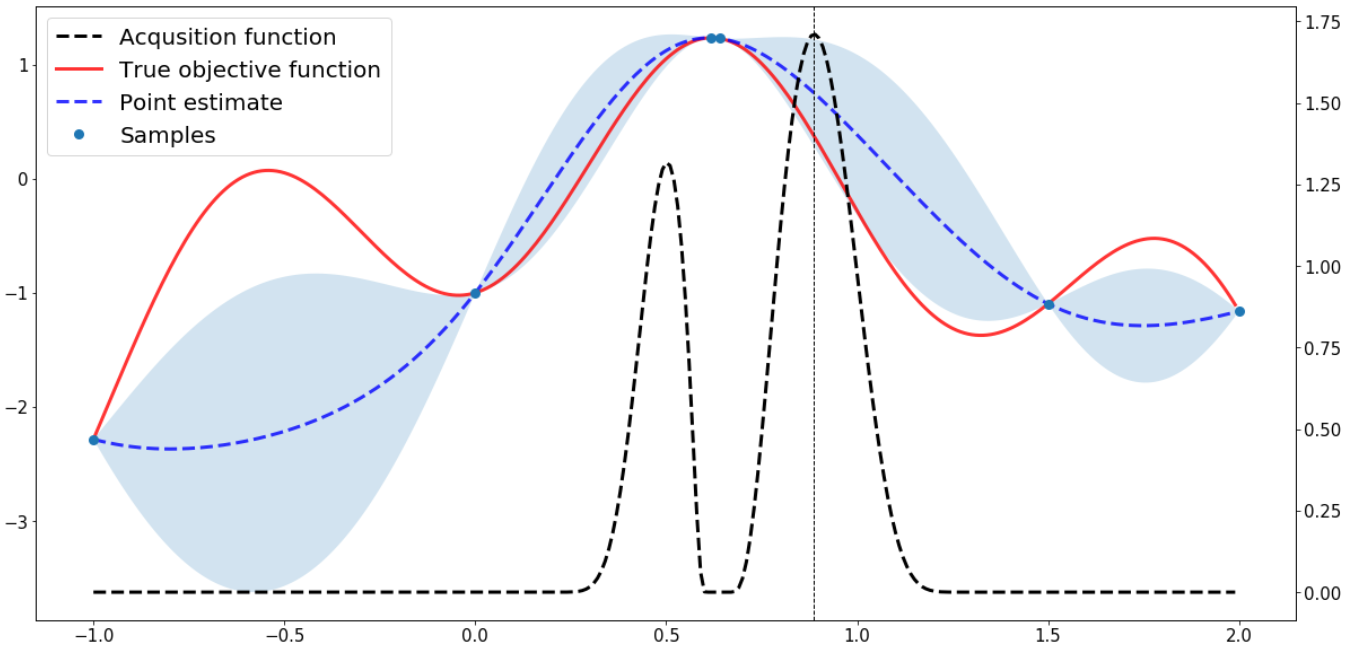

In [ ]:
comp = sess.autotune.modelComposer(
    table = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    nRounds = 2,
    nEvalsPerRound = 10,
    acquisitionFunction = 'EI',
    policyOptions = {
        'policy': 'epsGreedy',
        'epsGreedyOptions': {
            'eps': 0.25
        }
    },
    inputs = raw_inputs,
    target = 'bad',
    tunerOptions = {
        'objective': 'AUC',
        'enableLocalSearch': False,
        'popSize': 5,
        'nFolds': 3
    },
    nominals = ['bad'],
    modelTypes = [
        {
            'modelType': 'gradboost',
            'tuningOptions': {
                'trainOptions': {
                    'saveState': {
                        'name': 'comp_gb_ast',
                        'replace': True
                    }
                }
            }
        },
        {
            'modelType': 'forest',
            'tuningOptions': {
                'trainOptions': {
                    'saveState': {
                        'name': 'comp_forest_ast',
                        'replace': True
                    }
                }
            }
        }
    ]
)

In [ ]:
comp['TuneAllBestModels']

In [ ]:
if comp['TuneAllBestModels']['ModelID'][0].split('_')[2] == 'GradBoost':
    cmp_best = 'gb'
else:
    cmp_best = 'forest'
print(cmp_best)

## 3.5 Сравнение моделей

In [ ]:
# Функция для получения показателей качества модели
def assess_model(ast, table):
    sess.astore.score(
        table = table,
        rstore = ast,
        out = {
            'name': '__scored',
            'replace': True
        },
        copyVars = ['BAD']
    )
    return sess.percentile.assess(
        table = '__scored',
        inputs = [{'name': 'p_bad1'}],
        response = 'bad',
        event = '1',
        cutStep = 1 / len(sess.CASTable('__scored'))
    )

In [ ]:
models = ['forest_ast', 'gb_ast', 'forest_auto_ast', 'comp_%s_ast' % cmp_best]
names = {
    'forest_ast': 'Forest',
    'gb_ast': 'Gradient Boosting',
    'forest_auto_ast': 'Forest Autotuned',
    'comp_%s_ast' % cmp_best: 'Model Composer'
}

In [ ]:
assess_data = {
    a: assess_model(a, {'name': 'hmeq_train_val_abt', 'where': '_partind_ = 1'})
    for a in models
}

In [ ]:
assess_data['forest_ast']['ROCInfo'].head(5)

In [ ]:
for m in models:
    assess_data[m]['ROCInfo']['model'] = m
    assess_data[m]['ROCInfo']['model_name'] = names[m]
    assess_data[m]['LIFTInfo']['model'] = m
    assess_data[m]['LIFTInfo']['model_name'] = names[m]

In [ ]:
roc_data = pd.concat(assess_data[m]['ROCInfo'] for m in models)
lift_data = pd.concat(assess_data[m]['LIFTInfo'] for m in models)

In [ ]:
# Draw ROC charts 
plt.figure(figsize = (15, 4))
for key, grp in roc_data.groupby(['model_name']):
    plt.plot(grp['FPR'], grp['Sensitivity'], label = key)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend(loc = 'best')
plt.title('ROC Curve (using validation data)')
plt.show()

# Draw lift charts
plt.figure(figsize = (15, 4))
for key, grp in lift_data.groupby(['model_name']):
    plt.plot(grp['Depth'], grp['Lift'], label = key)
plt.xlabel('Depth')
plt.ylabel('Lift')
plt.grid(True)
plt.legend(loc = 'best')
plt.title('Lift Chart (using validation data)')
plt.show()

In [ ]:
aucs = roc_data.groupby(by = 'model')['C', 'model_name'] \
.max()\
.sort_values(by = 'C', ascending = False)\
.reset_index()
aucs

In [ ]:
champion_model = aucs.model[0]
print(champion_model)

## 4 Интерпретация работы модели

## 4.1 Partial Dependence

In [ ]:
r = sess.explainModel.partialDependence(
    analysisVariable = {
        'name': 'DEBTINC',
        'nBins': 25
    },
    inputs = raw_inputs,
    modelTable = champion_model,
    modelTableType = 'ASTORE',
    output = {
        'casout':{
            'name': 'pd_table',
            'replace': True
        },
        'copyVars': 'ALL'
    },
    predictedTarget = 'P_BAD1',
    sampleSize = 2000,
    table = {

        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    seed = 1234
)

In [ ]:
sess.CASTable('pd_table').columninfo()

In [ ]:
sess.CASTable('pd_table').groupby(by = 'DEBTINC')['P_BAD1'].mean(
    casout = {
        'name': 'mean',
        'replace': True
    }
)
_ = sess.dataStep.runCode(code = '''
    data pd_plot;
        set mean;
        ci_lower = _Mean_ - 1.96 * _Std_;
        ci_upper = _Mean_ + 1.96 * _Std_;
        p_bad1 = _Mean_;
        keep debtinc ci_lower ci_upper p_bad1;
    run;
'''
)

In [ ]:
pd_plot = sess.CASTable('pd_plot').to_frame().sort_values(by = 'DEBTINC')
fig = plt.figure(figsize = (20, 5))
plt.fill_between(pd_plot.DEBTINC, pd_plot.ci_lower, pd_plot.ci_upper, alpha = 0.7)
_ = plt.plot(pd_plot.DEBTINC, pd_plot.p_bad1, color = 'black')

## 4.2 Individual Conditional Expectations

### 4.2.1 Option 1

In [ ]:
ice_plot = sess.CASTable('pd_table').to_frame(fetchvars = ['Customer_ID', 'P_BAD1', 'DEBTINC'])

In [ ]:
plt.figure(figsize = (15, 4))
for i, (key, grp) in enumerate(ice_plot.groupby(['Customer_ID'])):
    plt.plot(grp['DEBTINC'], grp['P_BAD1'])
    if i >= 10:
        break
plt.xlabel('DEBTINC')
plt.ylabel('P_BAD1')
plt.grid(True)

### 4.2.2 Option 2

In [ ]:
obs = sess.CASTable('hmeq_train_val_abt').head(1)

In [ ]:
obs_dict = {
    k: obs[k][0]
    for k in sess.CASTable('hmeq_train_val_abt').columns
    if k not in {'Customer_ID', 'BAD', '_PartInd_'}
}

In [ ]:
sess.dataPreprocess.binning(
    table = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    inputs = ['DEBTINC'],
    nBinsArray = [50],
    casOutBinDetails = {
        'name': 'bins',
        'replace': True
    }
)
bins = sess.CASTable('bins').to_frame(fetchvars = ['_BinLowerBnd_', '_BinUpperBnd_'])
bins['mid'] = 0.5 * (bins['_BinLowerBnd_'] + bins['_BinUpperBnd_'])

In [ ]:
sas_code = 'data ice_samples;'
for var_name, value in obs_dict.items():
    if var_name == 'DEBTINC':
        continue
    if type(value) == np.float64:
        sas_code += '\n\t%s = %f;' % (var_name, value)
    else:
        sas_code += '\n\t%s = "%s";' % (var_name, value)
for b in bins.mid:
    sas_code += '\n\tDEBTINC = %f;' % b
    sas_code += '\n\toutput;'
sas_code += '\nrun;'
print(sas_code)

In [ ]:
sess.dataStep.runcode(code = sas_code)

In [ ]:
sess.astore.score(
    table = 'ice_samples',
    rstore = champion_model,
    casOut = {
        'name': 'ice_plot',
        'replace': True
    },
    copyVars = ['DEBTINC']
)

In [ ]:
ice_plot = sess.CASTable('ice_plot').to_frame(fetchvars = ['DEBTINC', 'P_BAD1']).sort_values(by = 'DEBTINC')
plt.figure(figsize = (15, 4))
plt.plot(ice_plot['DEBTINC'], ice_plot['P_BAD1'])
plt.xlabel('DEBTINC')
plt.ylabel('P_BAD1')
plt.grid(True)
_ = plt.title('ICE for Customer_ID = %d' % obs.Customer_ID[0])

## 4.3 LIME

In [ ]:
lime = sess.explainModel.linearExplainer(
    modelTable = champion_model,
    modelTableType = 'ASTORE',
    preset = 'LIME',
    inputs = raw_inputs,
    dataGeneration = {
        'binaryEncoding': 'NONE',
        'sampleSize': 1000
    },
    predictedTarget = 'P_BAD1',
    query = {
        'name': 'hmeq_train_val_abt',
        'where': 'Customer_ID = %d' % obs.Customer_ID[0]
    },
    table = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    seed = 1234
)

In [ ]:
lime.keys()

In [ ]:
lime['ParameterEstimates']

In [ ]:
ests = lime['ParameterEstimates'].copy()

cinfo = sess.CASTable('hmeq_train_val').columninfo()['ColumnInfo']

raw_inputs_nominals = list(cinfo.loc[cinfo.Type == 'char', 'Column'])

selected_nominals = \
{v for v in lime['ParameterEstimates'].Variable}\
.intersection(
    {
        v for v in raw_inputs_nominals
    }
)

for i in range(len(ests)):
    if ests.Variable[i] in selected_nominals:
        if ests.dtypes[ests.Variable[i]] == np.float64:
            ests.loc[i, 'Variable'] = ests.loc[i, 'Variable'] + ' (= %d)' % ests.loc[i, ests.loc[i, 'Variable']]
        else:
            ests.loc[i, 'Variable'] = ests.loc[i, 'Variable'] + ' (= "%s")' % ests.loc[i, ests.loc[i, 'Variable']]

ests = ests[['Variable', 'Estimate', 'QueryValue']].copy()

ests['AbsEstimate'] = ests.Estimate.apply(lambda x: abs(x))
ests.sort_values(by = 'AbsEstimate', inplace = True, ascending = False)

In [ ]:
ests

## 4.4 Kernel SHAP

In [ ]:
shap = sess.explainModel.linearExplainer(
    modelTable = champion_model,
    modelTableType = 'ASTORE',
    preset = 'KERNELSHAP',
    inputs = raw_inputs,
    dataGeneration = {
        'binaryEncoding': 'NONE',
        'sampleSize': 1000
    },
    predictedTarget = 'P_BAD1',
    query = {
        'name': 'hmeq_train_val_abt',
        'where': 'Customer_ID = %d' % obs.Customer_ID[0]
    },
    table = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    seed = 1234
)

In [ ]:
shap.keys()

In [ ]:
shap['ParameterEstimates']

In [ ]:
ests = shap['ParameterEstimates'].copy()

cinfo = sess.CASTable('hmeq_train_val').columninfo()['ColumnInfo']

raw_inputs_nominals = list(cinfo.loc[cinfo.Type == 'char', 'Column'])

selected_nominals = \
{v for v in lime['ParameterEstimates'].Variable}\
.intersection(
    {
        v for v in raw_inputs_nominals
    }
)

for i in range(len(ests)):
    if ests.Variable[i] in selected_nominals:
        if ests.dtypes[ests.Variable[i]] == np.float64:
            ests.loc[i, 'Variable'] = ests.loc[i, 'Variable'] + ' (= %d)' % ests.loc[i, ests.loc[i, 'Variable']]
        else:
            ests.loc[i, 'Variable'] = ests.loc[i, 'Variable'] + ' (= "%s")' % ests.loc[i, ests.loc[i, 'Variable']]

ests = ests[['Variable', 'Estimate']].copy()

ests['AbsEstimate'] = ests.Estimate.apply(lambda x: abs(x))
ests.sort_values(by = 'AbsEstimate', inplace = True, ascending = False)

In [ ]:
ests

# 5. Bonus track: Запуск автоматического конвеера разработки модели SAS AutoML

## 5.1 Оценка показателей качества данных

In [ ]:
sess.dataSciencePilot.exploreData(
    table = {
        'name': 'hmeq_train_val',
        'where': '_partind_ = 0' # Train partition
    },
    inputs = raw_inputs,
    casOut = {
        'name': 'explore_data',
        'replace': True
    }
)
sess.CASTable('explore_data').head(1000)

In [ ]:
r = sess.dataPreprocess.binning(
    table = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    inputs = ['MORTDUE'],
    nBinsArray = [50]
)
bins = r['BinDetails']
bins['mid'] = 0.5 * (bins.BinLowerBnd + bins.BinUpperBnd)

plt.figure(figsize = (10, 5))
_ = plt.bar(x = bins.mid, height = bins.NInBin, width = bins.BinWidth[0] * 0.9)

## 5.2 Оценка показателей зависимости переменных

In [ ]:
sess.dataSciencePilot.exploreCorrelation(
    table = {
        'name': 'hmeq_train_val',
        'where': '_partind_ = 0' # Train partition
    },
    inputs = raw_inputs,
    stats = {
        'intervalInterval': {'MI', 'SU'},
        'nominalInterval': {'MI', 'SU'},
        'nominalNominal': {'MI', 'SU'}
    },
    casOut = {
        'name': 'explore_correlation',
        'replace': True
    }
)
sess.CASTable('explore_correlation').head(1000).sort_values(by = 'SU', ascending = False)

### 5.2.1 Проверка зависимости переменных VALUE и MORTDUE

In [ ]:
df = sess.CASTable('hmeq_train_val_abt').query('_partind_ = 0').to_frame(fetchvars = ['VALUE', 'MORTDUE'])
_ = plt.plot(df.VALUE, df.MORTDUE, 'o', markersize = 3)

### 5.2.2 Проверка зависимости переменных VALUE и CLNO

In [ ]:
df = sess.CASTable('hmeq_train_val_abt').query('_partind_ = 0').to_frame(fetchvars = ['VALUE', 'CLNO'])
_ = plt.plot(df.VALUE, df.CLNO, 'o', markersize = 3)

## 5.3 Подбор преобразований для каждого признака (Feature Engineering)

In [ ]:
_ = sess.dataSciencePilot.featureMachine(
    table = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    inputs = raw_inputs,
    target = 'BAD',
    transformationPolicy = {
        'missing': True,
        'cardinality': True,
        'entropy': True,
        'iqv': True,
        'skewness': True,
        'kurtosis': True,
        'outlier': True
    },
    transformationOut = {
        'name': 'trans_out',
        'replace': True
    },
    featureOut = {
        'name': 'feature_list',
        'replace': True
    },
    saveState = {
        'name': 'features_ast',
        'replace': True
    }
)

In [ ]:
sess.CASTable('feature_list').head(100)

In [ ]:
fm_nominals = [v for v in sess.CASTable('feature_list').query('IsNominal = 1')['Name']]
fm_intervals = [v for v in sess.CASTable('feature_list').query('IsNominal = 0')['Name']]

In [ ]:
_ = sess.astore.score(
    table = 'hmeq_train_val_abt',
    rstore = 'features_ast',
    out = {
        'name': 'hmeq_train_val_abt_fm',
        'replace': True
    },
    copyVars = ['BAD', '_PartInd_', 'Customer_ID'] + raw_inputs
)

## 5.4 Анализ и отбор признаков

In [ ]:
sess.dataSciencePilot.screenVariables(
    table = {
        'name': 'hmeq_train_val_abt_fm',
        'where': '_partind_ = 0'
    },
    inputs = raw_inputs + fm_intervals + fm_nominals,
    target = 'bad',
    nominals = ['bad'] + fm_nominals,
    screenPolicy = {
        'redundant': 0.8
    },
    casOut = {
        'name': 'screen_variables',
        'replace': True
    }
)
sess.CASTable('screen_variables').head(100)

In [ ]:
vars_to_exclude = set(
    sess.CASTable('screen_variables')\
    .query('Recommendation = "remove"')\
    .to_frame(fetchvars = ['Variable']).Variable
)
exclude = lambda x: list(set(x).difference(vars_to_exclude))
raw_inputs_sc = exclude(raw_inputs)
fm_intervals_sc = exclude(fm_intervals)
fm_nominals_sc = exclude(fm_nominals)
for i, v in enumerate(raw_inputs_sc + fm_intervals_sc + fm_nominals_sc):
    print('%d\t%s' % (i, v))

## 5.5 Запуск всех шагов SAS AutoML в одном action

In [ ]:
r = sess.dataSciencePilot.dsAutoMl(
    table = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    inputs = raw_inputs,
    target = 'bad',
    modelTypes = [
        'forest',
        'gradboost'
    ],
    kFolds = 3,
    objective = 'AUC',
    sampleSize = 4, # maximum number of pipelines to sample
    transformationPolicy = {
        'missing': True,
        'cardinality': True,
        'entropy': True,
        'iqv': True,
        'skewness': True,
        'kurtosis': True,
        'outlier': True
    },
    transformationOut = {
        'name': 'transformation',
        'replace': True
    },
    featureOut = {
        'name': 'feature_list',
        'replace': True
    },
    pipelineOut = {
        'name': 'pipeline',
        'replace': True
    },
    saveState = {
        'replace': True,
        'modelNamePrefix': 'dsaml',
        'topK': 2
    },
    seed = 1234
)

In [ ]:
sess.CASTable('feature_list').head(100)

In [ ]:
df = sess.tableInfo()['TableInfo']
df.loc[df['Name'].apply(lambda s: s.startswith('DSAML_')) == 1, ['Name']]

### Short list лучший пайплайнов AutoML

In [ ]:
sess.CASTable('pipeline').head(100)

In [ ]:
best_pipeline = 'dsaml_' + sess.CASTable('pipeline') \
    .to_frame(fetchvars = ['MLType', 'Objective']) \
    .sort_values(by = 'Objective', ascending = False)['MLType'][0] \
    + '_1'
print(best_pipeline)

# 6. Выполнение скоринга в пакетном режиме

In [ ]:
sess.astore.score(
    rstore = 'DSAML_FM_',
    table = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 1'
    },
    casOut = {
        'name': 'tmp',
        'replace': True
    },
    copyVars = ['bad']
)
_ = sess.astore.score(
    rstore = best_pipeline,
    table = 'tmp',
    casOut = {
        'name': 'dsaml_scored',
        'replace': True
    },
    copyVars = ['bad']
)

### Оценка точности работы алгоритма

In [ ]:
ad = sess.percentile.assess(
    table = 'dsaml_scored',
    inputs = [{'name': 'p_bad1'}],
    response = 'bad',
    event = '1',
    cutStep = 1 / len(sess.CASTable('dsaml_scored'))
)
print('AUC ROC for the best pipeline = %f' % ad['ROCInfo']['C'][0])

# 7. Регистрация модели в репозитории Model Manager

In [ ]:
from sasctl import register_model, Session

In [ ]:
with swat.CAS(cashost, casport, casuser, password) as cas:
#    astore = cas.CASTable('model_astore_table')

    Session(password, casuser, password):

    model = register_model(astore, 'Model Name', 'Project Name')